<center><h1>Group 2404 </h1></center>


<center><style>
table {
    font-size: 24px;
}
</style></center>

| Last Name          | First Name            |Student Number|
|--------------------|-----------------------|----------------|
| Malagoli           | Pietro                |2125711         |
| Boccanera          | Eugenia               |2109310         |
| Braidi             | Federico              |2122169         |
| Lovato             | Matteo                |2104269         |           

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
# AdaBoost Algorithm
from sklearn.ensemble import AdaBoostClassifier
# Gradient Boosting 
from sklearn.ensemble import GradientBoostingClassifier
# XGBoost 
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance, to_graphviz, plot_tree
print("XGBoost version:",xgboost.__version__)
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split, cross_val_score

mycmap = "winter"
mpl.rcParams['image.cmap'] = mycmap
plt.rcParams['font.size'] = 13

XGBoost version: 2.0.3


In [2]:
np.random.seed(12345)

dname="./DATA/"
str0="_XGB_24.dat"
fnamex=dname+'x'+str0
fnamey=dname+'y'+str0
x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
y = np.loadtxt(fnamey)
y = y.astype(int)
N,L = len(x), len(x[0])

N_train = int(0.75*N)
x_train,y_train = x[:N_train],y[:N_train]
x_test,y_test = x[N_train:],y[N_train:]
print(f"N={N}, N_train={N_train}, L={L}")

N=4000, N_train=3000, L=4


[-31.608 -29.544   6.773   9.554] 0
[46.451 15.318 24.891 15.357] 1
[ 24.771  46.131 -49.161 -39.356] 1
[-20.13   15.641  30.981  37.218] 1
[46.465 22.369 14.248 21.745] 1


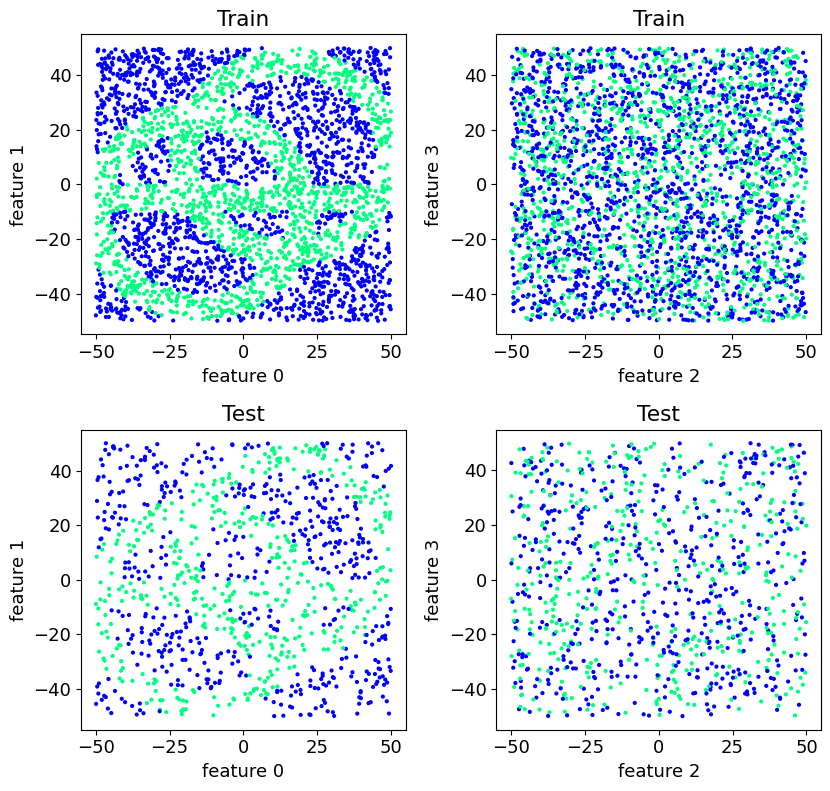

In [3]:
def scat(ax,x,y,i=0,j=1,s=4,title=""):
    ax.scatter(x[:,i],x[:,j],s=s,c=y)
    ax.set_xlabel(f"feature {i}")
    ax.set_ylabel(f"feature {j}")
    ax.set_title(title)

for n in range(5):
    print(x[n],y[n])

fig,AX = plt.subplots(2,2,figsize=(8.5,8.1))
scat(AX[0,0],x_train,y_train,title="Train")
scat(AX[0,1],x_train,y_train,i=2,j=3,title="Train")
scat(AX[1,0],x_test,y_test,title="Test")
scat(AX[1,1],x_test,y_test,i=2,j=3,title="Test")
fig.tight_layout()
plt.show()

In [4]:
def classify(clf=GradientBoostingClassifier(),show=False):
    # GradientBoostingClassifier():
    #   n_estimators = 100 (default)
    #   loss function = deviance(default) used in Logistic Regression
    # XGBClassifier()
    #   n_estimators = 100 (default)
    #   max_depth = 3 (default?)
    clf.fit(x_train,y_train)
    y_hat = clf.predict(x_test)
    
    #print("errors: {:.2f}%   Accuracy={:.3f}".format(100*(1-clf.score(x_test, y_test)),clf.score(x_test, y_test)))
    
    if show: 
        S=50
        dx = 1
        x_seq=np.arange(-S,S+dx,dx)
        nx = len(x_seq)
        x_plot=np.zeros((nx*nx,L))
        q=0
        for i in range(nx):
            for j in range(nx):
                x_plot[q,:2] = [x_seq[i],x_seq[j]]
                q+=1
        y_plot= clf.predict(x_plot)

        fig,AX = plt.subplots(1,2,figsize=(8.2,4))
        scat(AX[0],x_plot[:],y_plot,s=dx,title="predicted")
        scat(AX[1],x_train[:],y_train,title="training set")
        fig.tight_layout()
        plt.show()     
        dump_list = clf.get_booster().get_dump()
        num_trees = len(dump_list)
        print("num_trees=",num_trees)
        
        fig, AX = plt.subplots(2,1,figsize=(12, 5))
        for i in range(min(2,num_trees)):
            ax=AX[i]
            plot_tree(clf, num_trees=i, ax=ax)
        fig.savefig("DATA/tree-classif.png", dpi=400, pad_inches=0.02)   
        plt.show()
    
    return clf.score(x_test,y_test)

## Point 1

In [5]:
#hyperparameters grid
param_grid = {
    'learning_rate': [0.05, 0.1, 0.5, 1],
    'n_estimators': [ 20, 30, 100, 200, 300],
    'max_depth': [ 5, 7, 9, 11],
    'gamma': [0.05, 0.1, 0.5, 1, 1.5],
    'reg_lambda' : [ 0, 0.01, 0.1, 0.5, 1, 1.5,2]
}

In [6]:
best_accuracy= 0
best_params= {}

accuracies = []
param_combinations = []

for lr in param_grid['learning_rate']:
    for n_estimators in param_grid['n_estimators']:
        for max_depth in param_grid['max_depth']:
            for gamma in param_grid['gamma']:
                for reg_lambda in param_grid['reg_lambda']:
                    #initialize XGBoost classifier with current hyperparameters
                    xgb= XGBClassifier(learning_rate=lr, 
                                        n_estimators=n_estimators,
                                        max_depth= max_depth,
                                        gamma= gamma,
                                        reg_lambda= reg_lambda)
                    #train the calssifier
                    xgb.fit(x_train, y_train)
                    #evaluate on validation set
                    accuracy= xgb.score(x_test, y_test)
                    #check if the current model's accuracy is better than previous best accuracy
                    if accuracy > best_accuracy:
                        best_accuracy= accuracy 
                        best_params= {
                            'learning_rate': lr,
                            'n_estimators': n_estimators,
                            'max_depth': max_depth,
                            'gamma':gamma,
                            'reg_lambda': reg_lambda                           
                            }

                    # Store accuracy and corresponding parameters
                    accuracies.append(accuracy)
                    param_combinations.append((lr, n_estimators, max_depth, gamma, reg_lambda ))
print("Best parameters:", best_params)
print("Validation accuracy:", best_accuracy)

Best parameters: {'learning_rate': 0.05, 'n_estimators': 100, 'max_depth': 11, 'gamma': 0.5, 'reg_lambda': 0.01}
Validation accuracy: 0.96


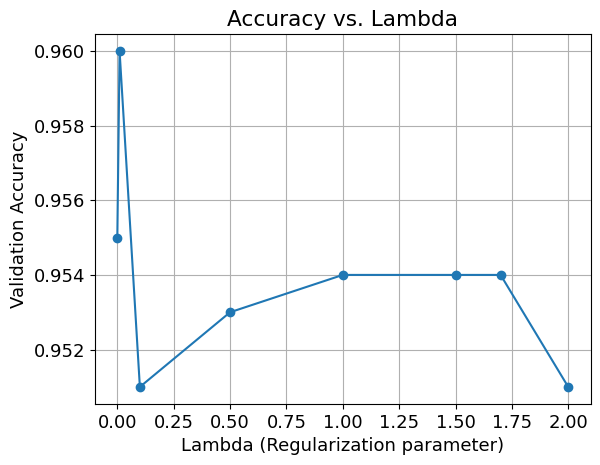

In [7]:
lambda_values = [0, 0.01, 0.1, 0.5, 1, 1.5, 1.7, 2]

# Initialize lists to store accuracy for each lambda value
accuracies = []

# Train XGBoost models with different lambda values and record accuracies
for reg_lambda in lambda_values:
    # Initialize XGBoost classifier with current lambda value
    xgb_with_reg = XGBClassifier(learning_rate=best_params['learning_rate'], 
                                 n_estimators=best_params['n_estimators'],
                                 max_depth=best_params['max_depth'],
                                 gamma= best_params['gamma'],
                                 reg_lambda=reg_lambda)
    # Train the classifier
    xgb_with_reg.fit(x_train, y_train)
    # Evaluate on validation set and record accuracy
    accuracy = xgb_with_reg.score(x_test, y_test)
    accuracies.append(accuracy)

# Plot accuracy vs. lambda
plt.plot(lambda_values, accuracies, marker='o')
plt.xlabel('Lambda (Regularization parameter)')
plt.ylabel('Validation Accuracy')
plt.title('Accuracy vs. Lambda')
plt.grid(True)
plt.show()

The model trained with regularization identified the best combination of hyperparameters as follows: learning_rate: 0.05, n_estimators: 100, max_depth: 11, gamma: 0.5, and reg_lambda: 0.01. It achieved an accuracy of 0.960.
On the other hand, without regularization, we obtained an accuracy of 0.955.

Regularization serves to prevent overfitting by reducing the complexity of the model and improves generalization performance. In this scenario, applying regularization (best_params) led to a slightly higher validation accuracy (0.960) compared to the model trained without regularization (0.955).

In the plotted results, it's evident that without regularization (reg_lambda=0), the accuracy is slightly lower. However, with reg_lambda=0.1, we achieve the highest accuracy for the model. Therefore, regularization does influence the model's accuracy, though not drastically.


## Point 2

In [8]:
from sklearn.metrics import accuracy_score
## best parameters from point 1 with regularization
model = XGBClassifier(reg_lambda=best_params['reg_lambda'],gamma=best_params['gamma'],n_estimators=best_params['n_estimators'],
                      max_depth=best_params['max_depth'],learning_rate=best_params['learning_rate'])
#print(x_train,'\n')
accuracy_values=[]
for i in range(4):
    x_train2=np.array(np.column_stack([x_train[:,j] for j in range(4) if j!=i]))
    x_test2=np.array(np.column_stack([x_test[:,j] for j in range(4) if j!=i]))
    #print(x_train2,'\n')
    model.fit(x_train2,y_train)
    y_pred2 = model.predict(x_test2)
    accuracy = accuracy_score(y_test,y_pred2)
    #model.score(x_test2,y_test)
    accuracy_values.append(accuracy)
    print("Accuracy without Feauture",i,":", accuracy,'\n',)

x_train2=np.array(np.column_stack([x_train[:,j] for j in [0,1]]))
x_test2=np.array(np.column_stack([x_test[:,j] for j in [0,1]]))
#print(x_train2,'\n')
model.fit(x_train2,y_train)
y_pred2 = model.predict(x_test2)
accuracy = accuracy_score(y_test,y_pred2)
#model.score(x_test2,y_test)
accuracy_values.append(accuracy)
print("Accuracy without Feauture 2 and 3:", accuracy,'\n',)

x_train2=np.array(np.column_stack([x_train[:,j] for j in [2,3]]))
x_test2=np.array(np.column_stack([x_test[:,j] for j in [2,3]]))

model.fit(x_train2,y_train)
y_pred2 = model.predict(x_test2)
accuracy = accuracy_score(y_test,y_pred2)
#model.score(x_test2,y_test)
accuracy_values.append(accuracy)
print("Accuracy without Feauture 0 and 1:", accuracy,'\n',)

Accuracy without Feauture 0 : 0.606 

Accuracy without Feauture 1 : 0.568 

Accuracy without Feauture 2 : 0.954 

Accuracy without Feauture 3 : 0.957 

Accuracy without Feauture 2 and 3: 0.96 

Accuracy without Feauture 0 and 1: 0.531 



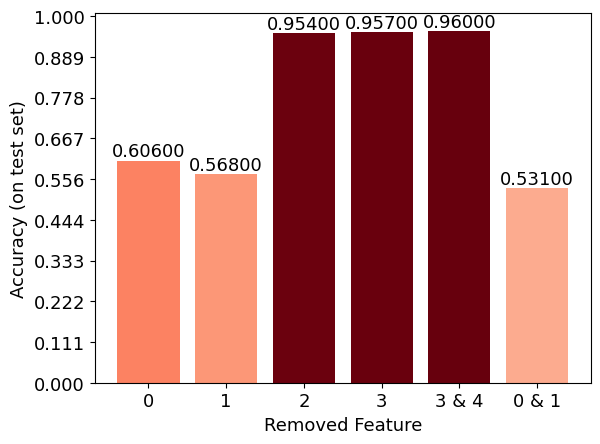

In [9]:
removed_features = ['0', '1', '2', '3','3 & 4','0 & 1']
rescale = lambda y: 0.3 + 0.7 * (y - np.min(y)) / (np.max(y) - np.min(y))

my_cmap=plt.get_cmap("Reds")
plt.bar(range(6), accuracy_values,color=my_cmap(rescale(accuracy_values)))
plt.xlabel("Removed Feature")
#plt.xticks(np.array([0,1,2,3]))
plt.xticks(range(6), removed_features)
plt.ylabel("Accuracy (on test set)")
plt.yticks(np.linspace(0,1,10))
for i, value in enumerate(accuracy_values):
    plt.text(i, value, f'{value:.5f}', ha='center', va='bottom')

As can be seen from the results above and as it was expected, when excluding one of the two or both of the most important features, namely features 0 and 1, the accuracy drops significantly. This confirms as these two features are the most relevant to classify the data. On the other hand, when excluding one of the two least important features or both, the accuracy is mostly the same as in the case of consider all the features.

## Point 3

In [10]:
def build_nn(num_layers,num_neurons,activation_function):
    input_shape = x.shape[1]
    model_nn = Sequential()
    model_nn.add(Dense(units=num_neurons, activation=activation_function, input_shape=(input_shape,)))
    for i in range(num_layers-1):
        model_nn.add(Dense(units=num_neurons, activation=activation_function))
    model_nn.add(Dense(units=2,activation='softmax'))
    opt = keras.optimizers.Adam()
    model_nn.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy'])
    return model_nn

num_layers=[2,3,4,5,6,7,8]                      #num of nn layers(input and output excluded)
num_neurons=[5,10,15,20,25,30]                        #num of neurons per layer
activation_functions=['relu']         #activation function for the hidden layers
max_acc=0
max_desc=""
perc=0.7
n_rep=15
num_indices=int(perc*len(x))        #get quantity of data points in training
data_indices = np.arange(len(x))    #get indices
mean_acc_list=[]

import gc

for nl in num_layers:
    for nn in num_neurons:
        for act in activation_functions:
            accuracies_nn=[]
            print(f"--RUNNING--n_lay: {nl}, n_neu: {nn}, act: {act}")
            for i in range(n_rep):
                np.random.shuffle(data_indices)     #shuffle indices
                train_indices = data_indices[:num_indices]  #get training set indices
                test_indices = data_indices[num_indices:]   #get test set indices
                
                x_train, y_train = x[train_indices], y[train_indices]
                x_test, y_test = x[test_indices], y[test_indices]
                y_train = keras.utils.to_categorical(y_train, num_classes=2)
                y_test = keras.utils.to_categorical(y_test, num_classes=2)
                
                
                model=build_nn(num_layers=nl,num_neurons=nn,activation_function=act)
                model.fit(x_train, y_train, validation_data=(x_test, y_test), verbose=0)
                accuracy_nn = model.evaluate(x_test, y_test, verbose=0)[1]  #accuracy is at index 1
                accuracies_nn.append(accuracy_nn)
                #print(accuracy_nn)
                del model,x_train,x_test,y_train,y_test,train_indices,test_indices      #just to free memory
                gc.collect()    #call garbage collector explicitly
            mean_acc=np.mean(accuracies_nn)
            mean_acc_list.append(mean_acc)
            print(mean_acc)
            if(mean_acc>max_acc):
                max_acc = mean_acc
                max_desc = f"n_lay: {nl}, n_neu: {nn}, act: {act}"
print(f"Best mean accuracy ({max_acc}) obtained by the model with parameters: {max_desc}")

--RUNNING--n_lay: 2, n_neu: 5, act: relu
0.5071111102898915
--RUNNING--n_lay: 2, n_neu: 10, act: relu
0.5177777767181396
--RUNNING--n_lay: 2, n_neu: 15, act: relu
0.5182222167650858
--RUNNING--n_lay: 2, n_neu: 20, act: relu
0.5331666707992554
--RUNNING--n_lay: 2, n_neu: 25, act: relu
0.5387222250302632
--RUNNING--n_lay: 2, n_neu: 30, act: relu
0.5404444495836894
--RUNNING--n_lay: 3, n_neu: 5, act: relu
0.5099444448947906
--RUNNING--n_lay: 3, n_neu: 10, act: relu
0.5267777701218923
--RUNNING--n_lay: 3, n_neu: 15, act: relu
0.5356666644414266
--RUNNING--n_lay: 3, n_neu: 20, act: relu
0.5513333360354106
--RUNNING--n_lay: 3, n_neu: 25, act: relu
0.5525000015894572
--RUNNING--n_lay: 3, n_neu: 30, act: relu
0.565833330154419
--RUNNING--n_lay: 4, n_neu: 5, act: relu
0.5267222205797831
--RUNNING--n_lay: 4, n_neu: 10, act: relu
0.5271111150582631
--RUNNING--n_lay: 4, n_neu: 15, act: relu
0.5482222239176432
--RUNNING--n_lay: 4, n_neu: 20, act: relu
0.558388884862264
--RUNNING--n_lay: 4, n_neu: 2

[[0.50711111 0.51777778 0.51822222 0.53316667 0.53872223 0.54044445]
 [0.50994444 0.52677777 0.53566666 0.55133334 0.5525     0.56583333]
 [0.52672222 0.52711112 0.54822222 0.55838888 0.5701111  0.57394444]
 [0.52788889 0.53811112 0.55233334 0.56183333 0.58322221 0.56894444]
 [0.53211112 0.55011111 0.55794445 0.56694444 0.57661111 0.57661111]
 [0.54544445 0.5515     0.56077778 0.57705555 0.57483332 0.57366666]
 [0.54416667 0.55327779 0.56366667 0.5685     0.57238888 0.57505556]]


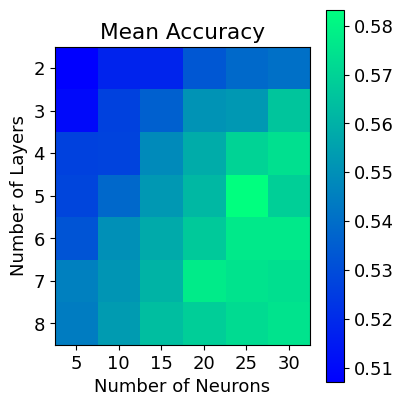

In [11]:
matrix=np.reshape(np.array(mean_acc_list),(len(num_layers),len(num_neurons)))
plt.matshow(matrix)
print(matrix)
plt.colorbar()
plt.xticks(ticks=np.arange(len(num_neurons)), labels=num_neurons)
plt.yticks(ticks=np.arange(len(num_layers)), labels=num_layers)
plt.tick_params(axis='x', bottom=True, top=False)
ax = plt.gca()
ax.xaxis.set_ticks_position('bottom')
ax.xaxis.set_label_position('bottom')
plt.xlabel('Number of Neurons')
plt.ylabel('Number of Layers')
plt.title('Mean Accuracy')
plt.show()

In [12]:
def build_best_xg():    #based on the result of point 1
    model_xg = XGBClassifier(
        reg_lambda=0.01,
        gamma=0.5, 
        n_estimators=100,
        max_depth=11,
        learning_rate=0.05)
    return model_xg

def build_best_nn():    #based on the previous analysis we choose the model with 6 hidden layers with 30 neurons each
    input_shape = x.shape[1]
    model_nn = Sequential()
    model_nn.add(Dense(30, activation='relu', input_shape=(input_shape,)))
    model_nn.add(Dense(30, activation='relu'))
    model_nn.add(Dense(30, activation='relu'))
    model_nn.add(Dense(30, activation='relu'))
    model_nn.add(Dense(30, activation='relu'))
    model_nn.add(Dense(30, activation='relu'))
    model_nn.add(Dense(2, activation='softmax'))
    opt = keras.optimizers.Adam()
    model_nn.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy'])
    return model_nn

In [13]:
train_perc = [0.03,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99]  #percentage of data to be used in training 
n_rep = 10                          #number of times training-test is repeated to get the statistic
mean_acc_best_xg = []
mean_acc_best_nn = []

for perc in train_perc:
    accuracies_best_xg = []
    accuracies_best_nn = []
    for i in range(n_rep):
        print(f"--RUNNING ({i+1}/{n_rep})--train_perc: {perc}")
        model_best_nn=build_best_nn()
        model_best_xg=build_best_xg()
        num_indices=int(perc*len(x))        #get quantity of data points in training
        data_indices = np.arange(len(x))    #get indices
        np.random.shuffle(data_indices)     #shuffle indices
        train_indices = data_indices[:num_indices]  #get training set indices
        test_indices = data_indices[num_indices:]   #get test set indices

        x_train, y_train = x[train_indices], y[train_indices]
        x_test, y_test = x[test_indices], y[test_indices]

        #XGBoost
        model_best_xg.fit(x_train, y_train)
        accuracy_best_xg = model_best_xg.score(x_test, y_test)
        accuracies_best_xg.append(accuracy_best_xg)

        #Neural Network
        y_train = keras.utils.to_categorical(y_train, num_classes=2)
        y_test = keras.utils.to_categorical(y_test, num_classes=2)
        model_best_nn.fit(x_train, y_train, validation_data=(x_test, y_test), verbose=0)
        accuracy_best_nn = model_best_nn.evaluate(x_test, y_test, verbose=0)[1]  #accuracy is at index 1
        accuracies_best_nn.append(accuracy_best_nn)

    mean_acc_best_xg.append(np.mean(accuracies_best_xg))
    mean_acc_best_nn.append(np.mean(accuracies_best_nn))
    print(f"Average accuracy on test set with XGBoost, cross-validation and {perc} of the data as training: {np.mean(accuracies_best_xg)}")
    print(f"Average accuracy on test set with dense NN and cross-validation and {perc} of the data as training: {np.mean(accuracies_best_nn)}")


--RUNNING (1/10)--train_perc: 0.03
--RUNNING (2/10)--train_perc: 0.03
--RUNNING (3/10)--train_perc: 0.03
--RUNNING (4/10)--train_perc: 0.03
--RUNNING (5/10)--train_perc: 0.03
--RUNNING (6/10)--train_perc: 0.03
--RUNNING (7/10)--train_perc: 0.03
--RUNNING (8/10)--train_perc: 0.03
--RUNNING (9/10)--train_perc: 0.03
--RUNNING (10/10)--train_perc: 0.03
Average accuracy on test set with XGBoost, cross-validation and 0.03 of the data as training: 0.6293556701030928
Average accuracy on test set with dense NN and cross-validation and 0.03 of the data as training: 0.5164175271987915
--RUNNING (1/10)--train_perc: 0.05
--RUNNING (2/10)--train_perc: 0.05
--RUNNING (3/10)--train_perc: 0.05
--RUNNING (4/10)--train_perc: 0.05
--RUNNING (5/10)--train_perc: 0.05
--RUNNING (6/10)--train_perc: 0.05
--RUNNING (7/10)--train_perc: 0.05
--RUNNING (8/10)--train_perc: 0.05
--RUNNING (9/10)--train_perc: 0.05
--RUNNING (10/10)--train_perc: 0.05
Average accuracy on test set with XGBoost, cross-validation and 0.05

[0.6293556701030928, 0.6795, 0.7704166666666666, 0.84721875, 0.8879285714285714, 0.9092499999999999, 0.9250499999999999, 0.9295000000000002, 0.9358333333333334, 0.9453750000000001, 0.9462499999999998, 0.9375]
[0.5164175271987915, 0.5283157914876938, 0.5426944434642792, 0.5535000026226043, 0.5608214318752289, 0.5660833299160004, 0.5647000074386597, 0.5798750042915344, 0.5810833275318146, 0.574874997138977, 0.5825000047683716, 0.5524999916553497]


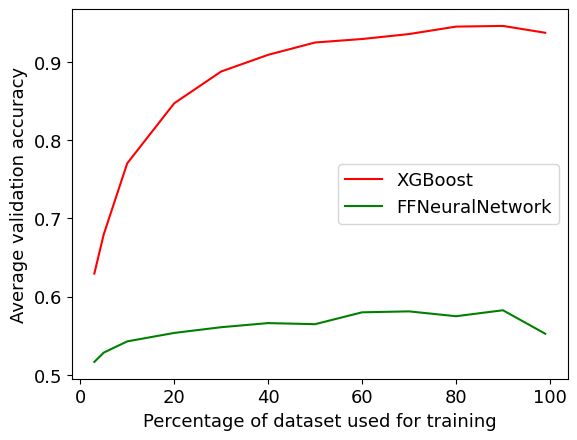

In [14]:
print(mean_acc_best_xg)
print(mean_acc_best_nn)

plt.plot([ perc*100 for perc in train_perc],mean_acc_best_xg,c="r",label="XGBoost")
plt.plot([ perc*100 for perc in train_perc],mean_acc_best_nn,c="g",label="FFNeuralNetwork")

plt.xlabel("Percentage of dataset used for training")
plt.ylabel("Average validation accuracy")
plt.legend()
plt.show()

As we can see from the graph the performance of XGBoost is significantly higher than the best NN we found even for small training sets. We see how, generally, for this problem a NN doesn't seem to be the right tool as the average accuracy is always pretty low. Due to problems with running the code (that we didn't find solution to yet) we have restricted the number of parameters and we acknowledge that there may be more complicated Networks that are better suited for this task.